In [1]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.linalg import eigh

#For Neural Network
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D,Dense,MaxPool3D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout, GlobalAveragePooling3D

In [2]:
BATCH_SIZE = 15
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def readImage(location,y_temp):
    image = nib.load(location)
    temp = np.array(image.get_fdata())[:,:,:,0]
    return (temp/temp.max()).astype(np.float32),y_temp

In [6]:
def PCA_manual(image):
    #Taking Covariance Matrix
    stacked = np.vstack((image.reshape(-1), image.reshape(-1)))
    cov = np.cov(stacked.T)
    val,eigen = eigh(cov)
    return np.matmul(eigen[-250:],temp.T).T.astype(np.float32)

In [8]:
pca = PCA(n_components=250)
def PCA2(image):
    image = image.reshape(1,-1)
    return pca.fit_transform(np.array(list(image)*250))[0]

In [9]:
def pool3D(arr,
           kernel=(10, 10, 10),
           stride=(5, 5, 5),
           func=np.nanmax,
           ):
    # check inputs
    assert arr.ndim == 3
    assert len(kernel) == 3

    # create array with lots of padding around it, from which we grab stuff (could be more efficient, yes)
    arr_padded_shape = arr.shape + 2 * np.array(kernel)
    arr_padded = np.zeros(arr_padded_shape, dtype=arr.dtype) * np.nan
    arr_padded[
    kernel[0]:kernel[0] + arr.shape[0],
    kernel[1]:kernel[1] + arr.shape[1],
    kernel[2]:kernel[2] + arr.shape[2],
    ] = arr

    # create temporary array, which aggregates kernel elements in last axis
    size_x = 1 + (arr.shape[0]-1) // stride[0]
    size_y = 1 + (arr.shape[1]-1) // stride[1]
    size_z = 1 + (arr.shape[2]-1) // stride[2]
    size_kernel = np.prod(kernel)
    arr_tmp = np.empty((size_x, size_y, size_z, size_kernel), dtype=arr.dtype)

    # fill temporary array
    kx_center = (kernel[0] - 1) // 2
    ky_center = (kernel[1] - 1) // 2
    kz_center = (kernel[2] - 1) // 2
    idx_kernel = 0
    for kx in range(kernel[0]):
        dx = kernel[0] + kx - kx_center
        for ky in range(kernel[1]):
            dy = kernel[1] + ky - ky_center
            for kz in range(kernel[2]):
                dz = kernel[2] + kz - kz_center
                arr_tmp[:, :, :, idx_kernel] = arr_padded[
                                               dx:dx + arr.shape[0]:stride[0],
                                               dy:dy + arr.shape[1]:stride[1],
                                               dz:dz + arr.shape[2]:stride[2],
                                               ]
                idx_kernel += 1

    # perform pool function
    arr_final = func(arr_tmp, axis=-1)
    return arr_final

In [52]:
def preprocess(subject,y_temp):
    subject = subject.numpy()
    #subject = subject.reshape(128,128,90)
    pooled = pool3D(subject).reshape(-1)
    return PCA2(pooled),y_temp

In [53]:
paths = np.array(glob.glob('./Dataset/*/*/*/*/*/*/*.nii'))

In [54]:
##Creating the pipeline
paths_train,paths_test,_,_ = train_test_split(paths,[0]*paths.shape[0],test_size=0.25)

In [55]:
def getLabel(path):
    path_decoded = path.numpy().decode()
    #print(path_decoded)
    name = path_decoded.split('\\')[1]
    #print(name)
    classes = np.array(["AD"])
    return readImage(path_decoded,(classes == name).astype(np.float32))


In [56]:
def tf_reshape(img,y):
    return tf.reshape(img,(250,)),tf.reshape(y,(1,))

In [57]:
readImage_wrapper = lambda x,y : tf.py_function(readImage,[x,y],[tf.float32,tf.float32])
preprocess_wrapper = lambda x,y : tf.py_function(preprocess, [x,y], [tf.float32,tf.float32])
getLabel_wrapper = lambda x : tf.py_function(getLabel, [x], [tf.float32,tf.float32])


In [58]:
def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(getLabel_wrapper, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(readImage_wrapper, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(preprocess_wrapper , num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(tf_reshape , num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [59]:
train_set = create_dataset(paths_train)
test_set = create_dataset(paths_test)


## Making the Model

In [60]:
#For low intensity segments
input_layer = Input(shape=(250),name='input')

model = Dense(128,activation='relu')(input_layer)
model = Dense(64, activation='relu')(model)
output = Dense(1, activation='sigmoid')(model)

In [61]:
model = Model(input_layer,output)

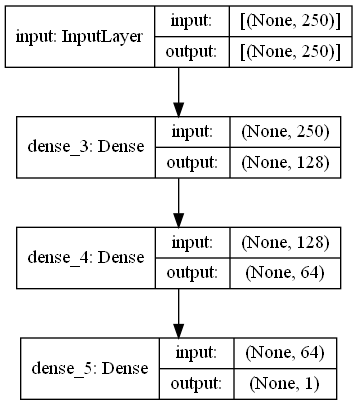

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [64]:
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_set,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_data=test_set)

Epoch 1/10
37/37 [==============================] - 105s 3s/step - loss: 0.6913 - accuracy: 0.5335 - val_loss: 0.6811 - val_accuracy: 0.6209
Epoch 2/10
37/37 [==============================] - 105s 3s/step - loss: 0.6846 - accuracy: 0.5854 - val_loss: 0.6755 - val_accuracy: 0.6209
Epoch 3/10
37/37 [==============================] - 112s 3s/step - loss: 0.6819 - accuracy: 0.5854 - val_loss: 0.6737 - val_accuracy: 0.6209
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.5862